### [OpenCV SIFT tutorial](https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html)

### [OpenCV feature extraction methods](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html) -- corner detectors, SIFT, SURF, FAST, BRIEF, and ORB

### [Implementing SFIT from scratch in Python](https://lerner98.medium.com/implementing-sift-in-python-36c619df7945#:~:text=SIFT%2C%20which%20stands%20for%20Scale,translation%2C%20rotation%2C%20and%20illumination)

### [feature extraction general(kaggle)](https://www.kaggle.com/lorinc/feature-extraction-from-images)

### [feature extraction general(classic + ML)](https://towardsdatascience.com/image-feature-extraction-traditional-and-deep-learning-techniques-ccc059195d04)

In [1]:
import sys, math
import os
from glob import glob

import matplotlib.pyplot as plt 
import numpy as np
import cv2 as cv
import skimage
import imageio

from sklearn import mixture
import colour
from astropy.io import fits
from colour.models import RGB_COLOURSPACES, RGB_luminance
from astrobf.utils.gmm import *

colorspace = RGB_COLOURSPACES['sRGB']

In [2]:
def gmm_mask(hdulist,
            max_n_comp = 30,
            max_iter_gmm = 300,
            tol_gmm = 0.0001,
            range_cut_min = 0.1,
            range_cut_max = 95.0,
            num_sample_x = 3000,
            sig_factor=3.0,
            verbose = True,
            do_plot = True):
    
    # Load image
    img_header = hdulist[0].header
    img_data = hdulist[0].data
    #hdulist.close()
    width=img_data.shape[0]
    height=img_data.shape[1]
    img_data_1d = img_data.reshape(-1, 1)
    num_pixels = width * height

    # Criteria to determine the number of components.
    # Note that these criteria don't tell you what's the best model, just the number of components.

    bic_list = [] # Bayesian Information Critetion
    aic_list = [] # Akaike Information Criterion
    aicc_list = [] # corrected Akaike Information Criterion
    model_list = []
    for n_comp in range(1, max_n_comp+1):
        gmm = mixture.GaussianMixture(n_components = n_comp, 
             covariance_type = 'full', tol = tol_gmm, max_iter = max_iter_gmm)
        #gmm = GMM(n_components = n_comp, max_iter = max_iter_gmm)
        model = gmm.fit(img_data_1d)
        model_list.append(model)
        bic_list.append(gmm.bic(img_data_1d))
        aic = gmm.aic(img_data_1d)
        aic_list.append(aic)
        aicc_list.append(gmm_aicc(aic, gmm._n_parameters(), num_pixels))

    if do_plot: plot_gmm_statstics(max_n_comp, bic_list, aic_list, aicc_list)

    best_n_comp, best_val = get_best_gmm(aic_list)

    if verbose: print("... best_n_comp: ", best_n_comp, " with criteria val: ", best_val)


    # set the best model
    best_model = model_list[best_n_comp-1]
    percent_values = np.percentile(img_data, [range_cut_min, range_cut_max])
    test_x = np.linspace(percent_values[0], percent_values[1], num_sample_x)
    logprob = best_model.score_samples(test_x.reshape(-1, 1))
    responsibilities = best_model.predict_proba(test_x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    if not best_model.converged_ :
        print("[PROBLEM] ... however, not converged.")
        sys.exit(1)

    pdf_comp_weights = best_model.weights_
    pdf_comp_means = best_model.means_
    pdf_comp_covariances = best_model.covariances_
    dominant_comp_ind = np.argmax(pdf_comp_weights)
    use_mean = pdf_comp_means[dominant_comp_ind].flatten()[0]
    use_std = math.sqrt(pdf_comp_covariances[dominant_comp_ind].flatten()[0])


    # sigma cut
    #use_factors = [1.0, 2.0, 3.0, 4.0, 5.0]
    #for use_factor in use_factors:
    use_factor = sig_factor
    cut_val = use_mean + use_factor*use_std
    binary_result = img_data > cut_val
    use_label, num_labels = measure.label(binary_result, background=0, return_num=True)
    min_label = np.min(use_label)
    max_label = np.max(use_label)
    if verbose: print("... num_labels: ", num_labels)

    # find the mean x, y for each label component
    num_label_region_dict = dict()
    mean_x_list = []
    mean_y_list = []
    mean_xy_distance_ratio_list = []

    for ind in range(1, max_label+1):
        selected_region_ind = np.argwhere(use_label == ind)
        num_label_region_dict[ind] = selected_region_ind.shape[0]
        if selected_region_ind.shape[0] == 1:
            mean_y, mean_x = selected_region_ind[0]
            #mean_y = selected_region_ind[0][0]
        else:    
            # [WARNING] because of pyplot image show convention and data indexing scheme,
            # x and y index should be used with caution.
            mean_y, mean_x = np.sum(selected_region_ind, axis=0)/selected_region_ind.shape[0]
        mean_x_list.append(mean_x)
        mean_y_list.append(mean_y)
        mean_xy_distance_ratio_list.append((mean_x/width - 0.5)**2 + (mean_y/height - 0.5)**2)

    # find the central object and its label
    best_label, best_ind = get_central_label(mean_xy_distance_ratio_list, max_label)
    if verbose: print("... best_label: %d with num_label_region: %d" % \
    (best_label, num_label_region_dict[best_label]))
    # target mask
    target_mask = np.zeros(img_data.shape, dtype=bool)    
    use_ind = np.where(use_label == best_label)
    if verbose: print("... use_ind.size: ", len(use_ind[0]))
    target_mask = np.zeros(img_data.shape, dtype=bool)
    target_mask[use_ind] = True

    # convex hull
    convex_hull_results = convex_hull_image(target_mask, offset_coordinates=False, tolerance=1e-20)
    if do_plot: plot_mixture_cut(img_data, use_label, 
                     convex_hull_results, binary_result, 
                     mean_x_list, mean_y_list, best_ind, 
                     use_factor=use_factor,
                     vmin=percent_values[0], vmax=percent_values[1])

    return target_mask, img_data

# 1. Start here, Load data

In [3]:
wdir = '../../bf_data/EFIGI_catalog/fits_temp_Dec_28/'

In [11]:
#wdir = '../../OBSdata/efigi-1.6/ima_r/'
fns_g = glob(wdir+"*/*g.fits")
fns_r = glob(wdir+"*/*r.fits")
fns_i = glob(wdir+"*/*i.fits")

fns_g.sort()
fns_r.sort()
fns_i.sort()

# 2. Build a mask (GMM)

In [6]:
fn = fns[0]
hdulist = fits.open(fn)

In [64]:
mask, img = gmm_mask(hdulist, sig_factor=2.0)

... best_n_comp:  5  with criteria val:  389684.734362
... num_labels:  983
... best_label: 392 with num_label_region: 3172
... use_ind.size:  3172


/home/hoseung/anaconda3/envs/tonemap/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


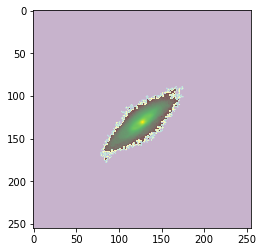

In [68]:
fig, ax = plt.subplots()
ax.imshow(np.log10(img))
ax.imshow(mask, alpha=0.3)
plt.show()

In [100]:
img[~mask] = 0

stamp = img[50:-50,50:-50]

# 3. Tone map

mapped min max 0.0 1.0


/home/hoseung/anaconda3/envs/tonemap/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


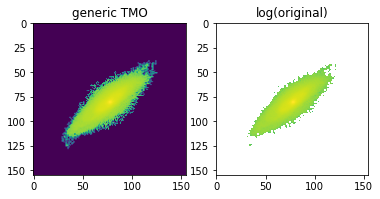

In [105]:
from astrobf import tmo

# Generic
# Ensure pixel values are positive
stamp[stamp>0] -= (stamp[stamp>0].min()-1e-10)
stamp[stamp<0] = 0
# TMO parameter need to adapt to pixel values (pixel min being above 0)
# Or just shift min to 0.
gene = tmo.Generic(stamp.max(),1.25,0.975,0.25,0.18)

mapped = gene.evaluate(stamp)
print("mapped min max", mapped.min(), mapped.max())

fig, axs = plt.subplots(1,2)
axs[0].imshow(mapped)
axs[0].set_title("generic TMO")
axs[1].imshow(np.log10(stamp))
axs[1].set_title("log(original)")
plt.show()

# 4. Feature extraction (SIFT)

Note that SIFT and SURF are **patented**, and they are missing from OpenCV install by default.  
You need additional component to be installed into opencv_contrib package. 

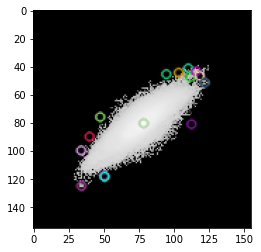

In [115]:
sift = cv.xfeatures2d.SIFT_create()
gray = (mapped*255).astype(np.uint8)
kp = sift.detect(gray,None)

shifted_img=cv.drawKeypoints(gray,kp,gray)

plt.imshow(shifted_img)
#cv.imwrite('sift_keypoints.jpg',shifted)

## What do they mean? How do I know I got reasonable feature set?